# Idealized Case 3: Tracking of a Test Blob in 3D

This tutorial shows the most important steps of tracking with `tobac` using an idealized case:

1. [Input Data](#1.-Input-Data)
2. [Feature Detection](#2.-Feature-Detection)
3. [Tracking / Trajectory Linking](#3.-Trajectory-Linking)
4. [Segmentation](#4.-Segmentation)
5. [Statistical Analysis](#5.-Statistical-Analysis)

## Import Libraries

We start by importing tobac:

In [ ]:
import tobac

print("using tobac version", str(tobac.__version__))

# We add testing here to create test dataset (typically not needed in standard applications)
import tobac.testing

using tobac version 1.5.5


We will also need matplotlib in inline-mode for plotting and numpy:

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

Tobac works with a Python package called `xarray`, which introduces `DataArrays`. In a nutshell these are `numpy`-arrays with labels. For a more extensive description have a look at the [xarray Documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray).

## 1. Input Data

    
There are several utilities implemented in tobac to create simple examples of such arrays. In this tutorial we will use the function `make_simple_sample_data_3D_1blob()` to create a moving test blob in 3D:

In [ ]:
test_data = tobac.testing.make_sample_data_3D_1blob(data_type="xarray")
test_data

<xarray.DataArray 'w' (time: 25, z: 20, y: 50, x: 100)> Size: 20MB
[2500000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 200B 2000-01-01T12:00:00 ... 2000-01-01T...
  * z          (z) float64 160B 0.0 1e+03 2e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 400B 0.0 1e+03 2e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 800B 0.0 1e+03 2e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 40kB ...
    longitude  (y, x) float64 40kB ...
Attributes:
    units:    m s-1

As you can see our generated data describes a field called 'w' with 25 datapoints of time and the unit m/s at 100, 50, 20 of x, y and z. Additionally, the data contains the latitude and longitude coordinates of the field values. To access the values of 'w' in the first timeframe, we can use

In [ ]:
test_data.data[0]

array([[[1.32998835e-01, 1.94482147e-01, 2.73237224e-01, ...,
         1.77393675e-66, 5.35682483e-68, 1.55419311e-69],
        [1.94482147e-01, 2.84388247e-01, 3.99550583e-01, ...,
         2.59400038e-66, 7.83320239e-68, 2.27267263e-69],
        [2.73237224e-01, 3.99550583e-01, 5.61347628e-01, ...,
         3.64443458e-66, 1.10052388e-67, 3.19298594e-69],
        ...,
        [1.26314698e-12, 1.84708036e-12, 2.59505110e-12, ...,
         1.68478381e-77, 5.08760627e-79, 1.47608385e-80],
        [2.81846188e-13, 4.12139337e-13, 5.79034168e-13, ...,
         3.75926082e-78, 1.13519840e-79, 3.29358826e-81],
        [6.04224961e-14, 8.83548849e-14, 1.24133983e-13, ...,
         8.05914474e-79, 2.43365084e-80, 7.06083078e-82]],

       [[1.52985076e-01, 2.23707719e-01, 3.14297620e-01, ...,
         2.04051297e-66, 6.16181524e-68, 1.78774761e-69],
        [2.23707719e-01, 3.27124349e-01, 4.59592566e-01, ...,
         2.98381067e-66, 9.01032747e-68, 2.61419578e-69],
        [3.14297620e-01, 

which is then just an array of numbers of the described shape.

To visualize the data, we can plot individual time frames using volume rendering with pyvista:

As for visualizing the 3D data with matplotlib, we need to import Axes3D.
When wanting to use volume rendering, whe need to import pyvista and set the jupyter_backend to enable interaction in the plot (only for jupyter notebooks).

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv

pv.set_jupyter_backend("trame")

Now lets define a function for plotting the data which takes our **test_data** and **time_steps**. 
The function plots the blob at different time steps in one plot. You can add or remove time_steps.

In [ ]:
def volume_rendering_vista(test_data, times):
    # Create grid (x, y, z are coordinates)
    x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
    grid = pv.StructuredGrid(x, y, z)

    pl = pv.Plotter()
    # Add the outline of the grid and axes
    pl.add_mesh(grid.outline(), color="black", line_width=1)
    pl.add_axes()

    for i, time_step in enumerate(times):
        blob = test_data.isel(time=time_step).values
        grid["w"] = blob.ravel()
        pl.add_volume(
            grid, scalars="w", cmap="viridis", opacity="sigmoid", clim=[-2, 5]
        )

    # pl.show()


time_steps = [0, 10, 20]
volume_rendering_vista(test_data, time_steps)

This tells as that our data is a single moving blob, which is what we are going the analyze with tobac now.

## 2. Feature Detection

The first step of the general working routine of tobac is the identification of features. This essentially means finding the maxima or minima of the data.

To use the according functions of tobac we need to specify:

- the thresholds below/above the features are detected
- the spacing of our data

The spacing of the temporal and spatial dimension can be extracted from the data using a build-in utility:

In [ ]:
dxy, dt = tobac.get_spacings(test_data)

To get an idea of which order of magnitude our thresholds should be, we check the maximum of our data:

In [ ]:
test_data.max()

<xarray.DataArray 'w' ()> Size: 8B
array(10.)

Since we know that our data will only have one maximum it is reasoable to choose 9 as our threshold, but keep in mind that we could also add multiple values here if our data would be more complex.

In [ ]:
threshold = 9

Now we are ready to apply the feature detection algorithm. Notice that this is a minimal input. The function has several other options we will cover in later tutorials.

In [ ]:
# %%capture
features = tobac.feature_detection_multithreshold(test_data, dxy, threshold)
# This shows the first five rows
features.head(5)

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,geopotential_height,projection_y_coordinate,projection_x_coordinate,latitude,longitude
0,0,1,4.0,10.000000,10.000000,33,9,1,2000-01-01 12:00:00,2000-01-01 12:00:00,4000.0,10000.000000,10000.000000,24.100000,150.100000
1,1,1,4.0,11.590909,13.522727,44,9,2,2000-01-01 12:02:00,2000-01-01 12:02:00,4000.0,11590.909091,13522.727273,24.135227,150.115909
2,2,1,4.0,13.431818,17.318182,44,9,3,2000-01-01 12:04:00,2000-01-01 12:04:00,4000.0,13431.818182,17318.181818,24.173182,150.134318
3,3,1,4.0,15.051282,20.666667,39,9,4,2000-01-01 12:06:00,2000-01-01 12:06:00,4000.0,15051.282051,20666.666667,24.206667,150.150513
4,4,1,4.0,16.681818,24.431818,44,9,5,2000-01-01 12:08:00,2000-01-01 12:08:00,4000.0,16681.818182,24431.818182,24.244318,150.166818


The ouputs tells us that features were found in 25 **frame**s  (index 0 to 24) of our data. The variable **idx** is 1 for every frames, which means that only 1 feature was found in every time step, as we expected. **vdim**, **hdim_1** and **hdim_2** are the position of this feature with respect to the z, y and x-indices.

We can plot the detected feature positions in the 3D grid.

In [ ]:
# Create a PyVista Plotter object
pl = pv.Plotter()

# Create grid
x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
grid = pv.StructuredGrid(x, y, z)

# Extract 3D coordinates of features
points = np.column_stack(
    [
        test_data.x.values[features["hdim_2"].astype(int)],
        test_data.y.values[features["hdim_1"].astype(int)],
        test_data.z.values[features["vdim"].astype(int)],
    ]
)

# Add grid outline and axes
pl.add_mesh(grid.outline(), color="black", line_width=1)
pl.add_axes()

labels = [f"({x}, {y}, {z})" for x, y, z in points]

# Collect visible points & labels for selected time steps
vis_points = points[time_steps]
vis_labels = [f"({x:.1f}, {y:.1f}, {z:.1f})" for x, y, z in vis_points]

# Add point labels for the selected time steps
pl.add_point_labels(vis_points, vis_labels, point_color="blue", point_size=10)

# Show the plot
# pl.show()

<vtkmodules.vtkRenderingCore.vtkActor2D(0x0000018011FE71C0) at 0x000001801351A740>

The function has succesfully detected the maximum of our data in the individual timeframes.

## 3. Trajectory Linking

After we are done finding the features and associated segments for each frame it is necessary for further analysis to keep track of those elements troughout time. Linking is the tool for that. It connects the features of the timesteps which belong together. We are going to use the *linking_trackpy()* function here. The required inputs are the features, the two spacings and a maximum velocity of the features.

In [ ]:
trajectories = tobac.linking_trackpy(features, test_data, dt=dt, dxy=dxy, v_max=100)

Frame 24: 1 trajectories present.


Unsurprisingly, one trajectory was found. The returned object is another Dataset:

In [ ]:
# This shows the first five rows
trajectories.head(5)

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,geopotential_height,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,0,1,4.0,10.000000,10.000000,33,9,1,2000-01-01 12:00:00,2000-01-01 12:00:00,4000.0,10000.000000,10000.000000,24.100000,150.100000,1,0 days 00:00:00
1,1,1,4.0,11.590909,13.522727,44,9,2,2000-01-01 12:02:00,2000-01-01 12:02:00,4000.0,11590.909091,13522.727273,24.135227,150.115909,1,0 days 00:02:00
2,2,1,4.0,13.431818,17.318182,44,9,3,2000-01-01 12:04:00,2000-01-01 12:04:00,4000.0,13431.818182,17318.181818,24.173182,150.134318,1,0 days 00:04:00
3,3,1,4.0,15.051282,20.666667,39,9,4,2000-01-01 12:06:00,2000-01-01 12:06:00,4000.0,15051.282051,20666.666667,24.206667,150.150513,1,0 days 00:06:00
4,4,1,4.0,16.681818,24.431818,44,9,5,2000-01-01 12:08:00,2000-01-01 12:08:00,4000.0,16681.818182,24431.818182,24.244318,150.166818,1,0 days 00:08:00


The new variable cell now indexes the features in the different time steps. Therefore we can use it to create a mask for our moving feature:

In [ ]:
track_mask = trajectories["cell"] == 1.0

This mask can then be used 
- to select the track:

In [ ]:
track = trajectories.where(track_mask).dropna()

- and to show the track in our 3D plots: 

In [ ]:
# Create a PyVista Plotter object
pl = pv.Plotter()

# Create grid
x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
grid = pv.StructuredGrid(x, y, z)

# Add grid outline and axes
pl.add_mesh(grid.outline(), color="black", line_width=1)
pl.add_axes()

# Extract 3D coordinates of features
points = np.column_stack(
    [
        test_data.x.values[features["hdim_2"].astype(int)],
        test_data.y.values[features["hdim_1"].astype(int)],
        test_data.z.values[features["vdim"].astype(int)],
    ]
)

tracks = np.column_stack(
    [
        test_data.x.values[track["hdim_2"].astype(int)],
        test_data.y.values[track["hdim_1"].astype(int)],
        test_data.z.values[track["vdim"].astype(int)],
    ]
)

labels = [f"({x}, {y}, {z})" for x, y, z in points]

# Collect visible points & labels for selected time steps
vis_points = points[time_steps]
vis_labels = [f"({x:.1f}, {y:.1f}, {z:.1f})" for x, y, z in vis_points]

# Add point labels for the selected time steps
pl.add_point_labels(vis_points, vis_labels, point_color="blue", point_size=10)

# Create the connectivity array for lines
lines = []
for i in range(len(tracks) - 1):
    lines.append([2, i, i + 1])

# Flatten the list of lines for the connectivity array
lines = np.array(lines).flatten()

# Create the PolyData object with the line segments
track_poly = pv.PolyData(tracks)
track_poly.lines = lines

# Add tracks to the plot
pl.add_mesh(track_poly, color="red", line_width=3)

# Show the plot
# pl.show()

Actor (0x1801353ff40)
  Center:                     (53000.0, 29500.0, 4000.0)
  Pickable:                   True
  Position:                   (0.0, 0.0, 0.0)
  Scale:                      (1.0, 1.0, 1.0)
  Visible:                    True
  X Bounds                    1.000E+04, 9.600E+04
  Y Bounds                    1.000E+04, 4.900E+04
  Z Bounds                    4.000E+03, 4.000E+03
  User matrix:                Identity
  Has mapper:                 True

Property (0x1801353eec0)
  Ambient:                     0.0
  Ambient color:               Color(name='red', hex='#ff0000ff', opacity=255)
  Anisotropy:                  0.0
  Color:                       Color(name='red', hex='#ff0000ff', opacity=255)
  Culling:                     "none"
  Diffuse:                     1.0
  Diffuse color:               Color(name='red', hex='#ff0000ff', opacity=255)
  Edge color:                  Color(name='black', hex='#000000ff', opacity=255)
  Edge opacity:                1.0
  Interpol

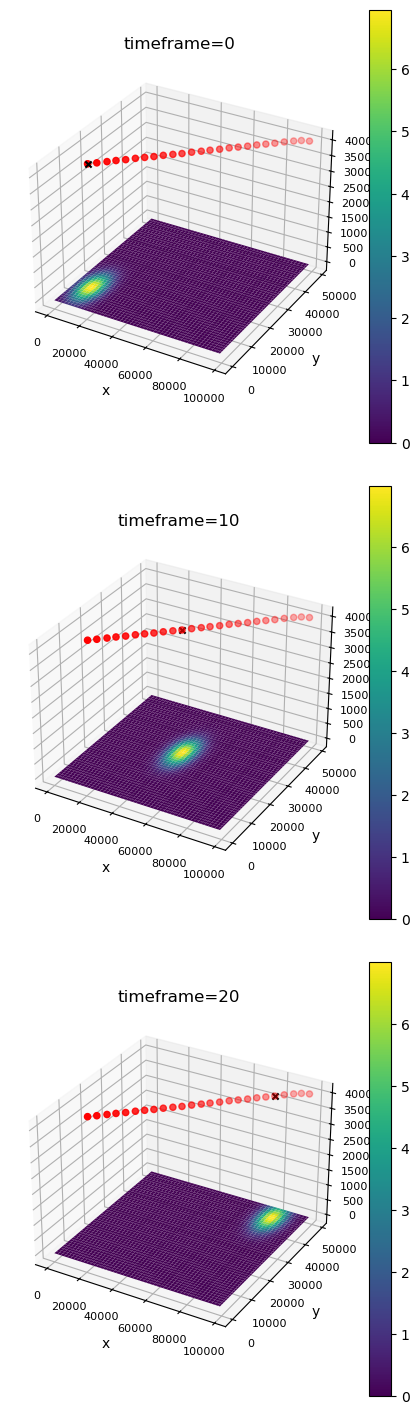

In [ ]:
# Create the figure with 3 subplots (one for each time step)
fig = plt.figure(figsize=(12, 18))

for i, itime in enumerate(time_steps):
    data_at_time = test_data.isel(time=itime, z=0)

    # Generate the grid for x and y coordinates
    x, y = np.meshgrid(data_at_time.coords["x"], data_at_time.coords["y"])
    z = data_at_time.values

    # Create a subplot for the scatter plot (right column)
    ax_scatter = fig.add_subplot(3, 2, 2 * i + 2, projection="3d")

    # Plot the surface for the current time step
    surf = ax_scatter.plot_surface(x, y, z, cmap="viridis")
    fig.colorbar(surf, ax=ax_scatter)

    # Plot the track
    ax_scatter.scatter(
        [track["projection_x_coordinate"]],
        [track["projection_y_coordinate"]],
        [track["geopotential_height"]],
        marker="o",
        color="red",
    )
    f = features.loc[[itime]]
    ax_scatter.scatter(
        [f["projection_x_coordinate"]],
        [f["projection_y_coordinate"]],
        [f["geopotential_height"]],
        marker="x",
        color="black",
    )

    # Set labels and title for the scatter plot
    ax_scatter.set_xlabel("x", fontsize=10)
    ax_scatter.set_ylabel("y", fontsize=10)
    ax_scatter.set_zlabel("w[m s-1]")
    ax_scatter.set_title(f"timeframe={itime}")

    # Adjust the tick label sizes for the scatter plot axes
    ax_scatter.tick_params(axis="x", labelsize=8)
    ax_scatter.tick_params(axis="y", labelsize=8)
    ax_scatter.tick_params(axis="z", labelsize=8)

# Adjust layout and display the plot
plt.subplots_adjust(hspace=0.1)
# plt.show()

## 4. Segmentation

Another step after the feature detection and tracking is the segmentation of the data. This means we find the area surrounding our features belonging to the same cluster. Logically, we now need the already detected features as an additional input.



*Just a small thought here:* 

We often introduce the different steps as 1.feature detection, 2.segmentation and 3. tracking, so having the segmenation step actually before the trajectory linking. The order actually does not matter since the current segmentation approach is based on the feature detection output only and can be done before or after the linking.


*On further extensions:*

- Also, one could actually use the output of the segmentation (`segments` Dataset in the example below) as input for the tracking with the advantage that information on the area (ncells) is added in the dataframe. 

- One could also use the output of the tracking in the segmentation (`trajectories` Dataset from above) with the advantage that mask will contain only the features that are also linked to trajectories. 

These possibilities exist and could be utlized by you ...

In [ ]:
segment_labels, segments = tobac.segmentation_3D(features, test_data, dxy, threshold=9)

As the name implies, the first object returned is an array in which the segmented areas belonging to each feature have the same label value as that feature. The second output is a dataframe of the detected features updated with information about their segmented regions (currently only the number of pixels segmented)

In [ ]:
segment_labels

<xarray.DataArray 'segmentation_mask' (time: 25, z: 20, y: 50, x: 100)> Size: 20MB
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
...
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], shape=(25, 20, 50, 100))
Coordinates:
  * time       (time) datetime64[ns] 200B 2000-01-01T12:00:00 ... 2000-01-01T...
  * z          (z) float64 160B 0.0 1e+03 2e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 400B 0.0 1e+03 2e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 800B 0.0 1e+03 2e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 40kB ...
    longitude  (y, x) float64 40kB ...
Attributes:
    units:      m s-1
    threshold:  9

***Exploration of Segmented Data at Varying Thresholds***

Next, we investigate the segmented data using different threshold values. To facilitate this analysis, we visualize the segments across various time steps, displaying the segmentation results at different threshold levels within a single 3D plot. 

In [ ]:
thresholds = [3, 6, 9]
segment_labels_0, segments_0 = tobac.segmentation_3D(
    features, test_data, dxy, threshold=thresholds[0]
)
segment_labels_1, segments_1 = tobac.segmentation_3D(
    features, test_data, dxy, threshold=thresholds[1]
)
segment_labels_2, segments_2 = tobac.segmentation_3D(
    features, test_data, dxy, threshold=thresholds[2]
)
segment_label = [segment_labels_0, segment_labels_1, segment_labels_2]
segments = [segments_0, segments_1, segments_2]

In [ ]:
# Create grid for PyVista
x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
grid = pv.StructuredGrid(x, y, z)
# Create plotter
pl = pv.Plotter()
# Outline the grid for reference
pl.add_mesh(grid.outline(), color="black")

time_steps = [0, 10, 20]
for i, time_step in enumerate(time_steps):
    labels = segment_label[i][time_step].values
    grid["w"] = labels.ravel()
    # Visualize the segmentation labels
    pl.add_volume(grid, scalars="w", cmap="viridis", opacity="linear")

# Add axes and show the plot
pl.add_axes()
# pl.show()

<vtkmodules.vtkRenderingAnnotation.vtkAxesActor(0x000001800A009E40) at 0x000001801351BAC0>

That shows that the area of the resulting segments crucially depends on the defined thresholds.

## 5. Statistical Analysis
### Blob Velocity / Motion Speed
Now different functions of tobacs analysis module can be used to calculate or plot properties of the tracks and the features. For example the velocity of the feature along the track can be calulated via:

In [31]:
vel = tobac.calculate_velocity(track)

The expected velocity (hard-coded in the test function) is:

In [32]:
expected_velocity = np.sqrt(30**2 + 14**2)

Plotting the velocity vs the timeframe will give us

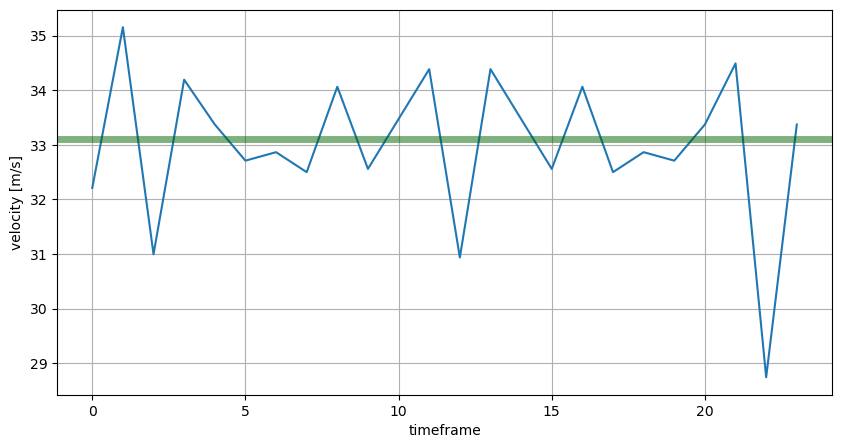

In [34]:
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.plot(vel["frame"], vel["v"])

plt.xlabel("timeframe")
plt.ylabel("velocity [m/s]")
plt.grid()

plt.axhline(expected_velocity, color="darkgreen", lw=5, alpha=0.5)

We can also create an histogram of the detected velocities:

In [35]:
hist, edges = tobac.velocity_histogram(
    track,
    bin_edges=np.arange(14, 43, 3),
)

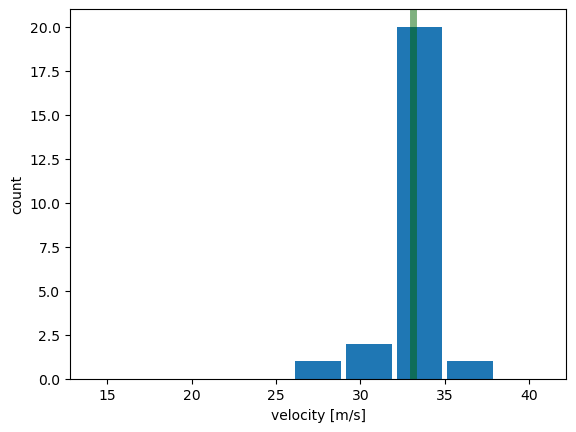

In [36]:
width = 0.9 * (edges[1] - edges[0])
center = (edges[:-1] + edges[1:]) / 2

plt.tight_layout()
plt.bar(center, hist, width=width)
plt.ylabel("count")
plt.xlabel("velocity [m/s]")

plt.axvline(expected_velocity, color="darkgreen", lw=5, alpha=0.5)

### Area

The area of the features can also be calculated and plotted throughout time:

In [37]:
area = tobac.calculate_area(features, segment_labels)

In [38]:
blob_magitude = 10  # also hard-code in the test
blob_sigma = 5e3

normalized_circle_radius = np.sqrt(np.log(blob_magitude / threshold))
absolute_circle_radius = np.sqrt(2) * blob_sigma * normalized_circle_radius
expected_area = np.pi * absolute_circle_radius**2

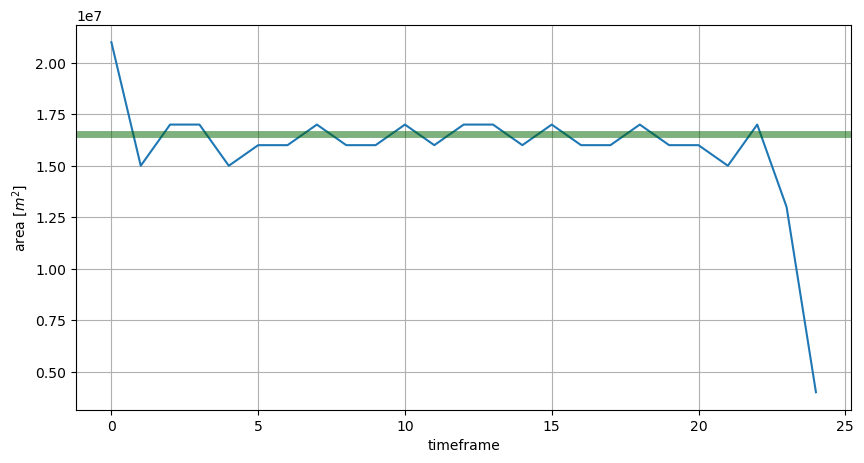

In [39]:
plt.figure(figsize=(10, 5))
plt.tight_layout()
plt.plot(area["frame"], area["area"])
plt.xlabel("timeframe")
plt.ylabel(r"area [$m^2$]")
plt.grid()

plt.axhline(expected_area, color="darkgreen", lw=5, alpha=0.5)

### Lifetime

Another interesting property for real data are the lifetimes of our features. Tobac can also produce a histogram of this:

In [40]:
hist, bins, centers = tobac.lifetime_histogram(track, bin_edges=np.arange(0, 200, 20))

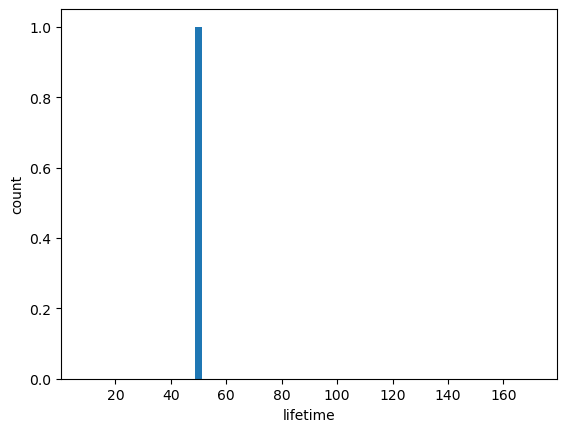

In [41]:
plt.tight_layout()
plt.bar(centers, hist, width=width)
plt.ylabel("count")
plt.xlabel("lifetime")
plt.show()

We can deduce, that our singular feature in the data has a lifetime of 50.